# Feature Importance - Confiança do Estudante

Este notebook utiliza um **Random Forest Regressor** (modelo não-linear) para identificar quais variáveis mais influenciam a confiança do estudante em conduzir pesquisas após a disciplina.

## Objetivo

Responder à pergunta: **"O que mais influencia a confiança do estudante?"**

O modelo irá identificar a importância relativa de variáveis como:
- Motivação
- Engajamento
- Conhecimento Prévio
- Curso
- Outras variáveis relevantes


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Configuração de estilo profissional para artigos
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans'],
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14,
    'axes.linewidth': 1.2,
    'grid.alpha': 0.3,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1
})

# Paleta de cores profissional (adequada para impressão)
colors_professional = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E', 
                       '#BC4749', '#F77F00', '#FCBF49', '#8E9AAF']
sns.set_palette(colors_professional)


In [2]:
# Carregar os dados
df = pd.read_csv("../csv/feedback-v2.csv")
df.columns = df.columns.str.strip()

print(f"Shape do dataset: {df.shape}")
print(f"\nColunas disponíveis: {len(df.columns)}")
df.head()


Shape do dataset: (21, 38)

Colunas disponíveis: 38


,Carimbo de data/hora,Coluna 1,Coluna 2,Qual sua matrícula?,Qual o seu curso?,Qual o seu semestre atual?,Como você se identifica em relação ao gênero,"Antes da disciplina, qual era o seu nível de conhecimento em Engenharia de Software Experimental?","Antes da disciplina, quais conteúdos de Engenharia de Software Experimental você já havia utilizado na condução de estudos?","Qual seu nível de conhecimento sobre tipos de estudos experimentais (primários, secundários e terciários) antes da disciplina?",...,Experimento controlado,Estudo de caso,Survey,Revisão Sistemática da Literatura (RSL),Análise Estatística de Experimentos,Análise Qualitativa,O que mais impactou na sua motivação para o aprendizado durante a disciplina?,Você acredita que a disciplina vai contribuir para sua formação?,Conte-nos como a disciplina pode contribuir para sua formação.,Há algo mais que gostaria de nos dizer sobre a metodologia da disciplina?
0,30/07/2025 09:08:48,Declaro que tenho mais de 18 anos e que minha ...,Consinto na utilização dos meus dados pessoais...,574238,Engenharia de Software,7º ao 8º semestre,Homem,Baixo. Adquiri conhecimentos básicos sobre Eng...,Nunca conduzi um estudo.,0,...,Muito motivado(a),Muito motivado(a),Muito motivado(a),Neutro(a),Muito motivado(a),Muito motivado(a),Perceber que o que era utilizado em aula podia...,Concordo totalmente,Utilizarei os conhecimentos que aprendi para f...,NaN
1,30/07/2025 09:14:35,Declaro que tenho mais de 18 anos e que minha ...,Consinto na utilização dos meus dados pessoais...,499351,Engenharia de Software,7º ao 8º semestre,Homem,Baixo. Adquiri conhecimentos básicos sobre Eng...,Obtenção de dados através de formulários e aná...,0,...,Motivado(a),Muito motivado(a),Muito motivado(a),Neutro(a),Motivado(a),Muito motivado(a),As aplicações práticas das técnicas passadas a...,Concordo totalmente,Acredito que irá contribuir pelo fato de ter s...,NaN
2,30/07/2025 09:16:41,Declaro que tenho mais de 18 anos e que minha ...,Consinto na utilização dos meus dados pessoais...,537725,Engenharia de Software,7º ao 8º semestre,Mulher,Baixo. Adquiri conhecimentos básicos sobre Eng...,"Realização de Surveys, experimento controlado,...",2,...,Muito motivado(a),Motivado(a),Motivado(a),Muito motivado(a),Muito motivado(a),Muito motivado(a),Ser uma pessoa que gosta de pesquisa científica,Concordo totalmente,A disciplina fez com que eu tivesse mais confi...,"Foi uma proposta interessante, normalmente as ..."
3,30/07/2025 09:18:18,Declaro que tenho mais de 18 anos e que minha ...,Consinto na utilização dos meus dados pessoais...,475320,Ciência da computação,7º ao 8º semestre,Homem,Nenhum. Não conhecia Engenharia de Software Ex...,Nenhum,0,...,Motivado(a),Neutro(a),Motivado(a),Neutro(a),Motivado(a),Motivado(a),A forma como a professora conduziu as aulas ex...,Concordo,Para mim que penso em fazer mestrado e visto q...,NaN
4,30/07/2025 09:27:18,Declaro que tenho mais de 18 anos e que minha ...,Consinto na utilização dos meus dados pessoais...,540240,Engenharia de Software,7º ao 8º semestre,Homem,Baixo. Adquiri conhecimentos básicos sobre Eng...,Gerência de projetos de software,1,...,Motivado(a),Motivado(a),Motivado(a),Neutro(a),Muito motivado(a),Neutro(a),Análise estatística de experimentos,Concordo,Na parte da experiência em aprender e apresent...,NaN


In [3]:
# Preparar a variável target: Capacidade de Condução (Confiança)
scale = {
    "Concordo Totalmente": 4,
    "Concordo": 3,
    "Nem concordo, nem discordo": 2,
    "Discordo": 1,
    "Discordo Totalmente": 0
}

df['Confianca'] = df['Você se sente mais capaz de conduzir pesquisas com conteúdos de Engenharia de Software Experimental após a disciplina?'] \
    .map(scale)

print("Distribuição da variável target (Confiança):")
print(df['Confianca'].value_counts().sort_index())


Distribuição da variável target (Confiança):
Confianca
3    11
4    10
Name: count, dtype: int64


In [4]:
# Preparar variáveis de Motivação
motiv_scale = {
    "Desmotivado(a)": 1,
    "Neutro(a)": 2,
    "Motivado(a)": 3,
    "Muito motivado(a)": 4
}

motiv_cols = [
    "Estudo de caso",
    "Survey", 
    "Revisão Sistemática da Literatura (RSL)", 
    "Análise Estatística de Experimentos", 
    "Análise Qualitativa"
]

for col in motiv_cols:
    if col in df.columns:
        df[col] = df[col].map(motiv_scale)

# Criar uma variável agregada de Motivação (média)
df['Motivacao_Media'] = df[motiv_cols].mean(axis=1)


In [5]:
# Preparar variável de Conhecimento Prévio
conhecimento_scale = {
    "Nenhum. Não conhecia Engenharia de Software Experimental.": 0,
    "Baixo. Adquiri conhecimentos básicos sobre Engenharia de Software Experimental em aulas ou livros.": 1,
    "Médio. Já havia utilizado conceitos de Engenharia de Software Experimental em projetos de pesquisa.": 2,
    "Alto. Já havia utilizado conceitos de Engenharia de Software Experimental em cinco ou mais projetos.": 3
}

df['Conhecimento_Previo'] = df['Antes da disciplina, qual era o seu nível de conhecimento em Engenharia de Software Experimental?'] \
    .map(conhecimento_scale)

print("Distribuição do Conhecimento Prévio:")
print(df['Conhecimento_Previo'].value_counts().sort_index())


Distribuição do Conhecimento Prévio:
Conhecimento_Previo
0    9
1    9
2    3
Name: count, dtype: int64


In [6]:
# Preparar variável de Engajamento (Percepção de Contribuição)
engajamento_scale = {
    "Discordo totalmente": 1,
    "Discordo": 2,
    "Neutro": 3,
    "Concordo": 4,
    "Concordo totalmente": 5
}

df['Engajamento'] = df['Você acredita que a disciplina vai contribuir para sua formação?'] \
    .map(engajamento_scale) \
    .fillna(3)

print("Distribuição do Engajamento:")
print(df['Engajamento'].value_counts().sort_index())


Distribuição do Engajamento:
Engajamento
4     5
5    16
Name: count, dtype: int64


In [7]:
# Preparar variável de Curso (se disponível)
# Verificar se há coluna de curso
curso_cols = [col for col in df.columns if 'curso' in col.lower() or 'Curso' in col]
print(f"Colunas relacionadas a curso: {curso_cols}")

# Se houver coluna de curso, codificar
if curso_cols:
    le_curso = LabelEncoder()
    df['Curso_Codificado'] = le_curso.fit_transform(df[curso_cols[0]].astype(str))
    print(f"\nCursos únicos: {df[curso_cols[0]].unique()}")
else:
    # Criar variável dummy se não houver curso
    df['Curso_Codificado'] = 0
    print("\nNenhuma coluna de curso encontrada. Usando valor padrão.")


Colunas relacionadas a curso: ['Qual o seu curso?']

Cursos únicos: ['Engenharia de Software' 'Ciência da computação']


In [8]:
# Selecionar features para o modelo
features = [
    'Motivacao_Media',
    'Conhecimento_Previo',
    'Engajamento',
    'Curso_Codificado'
] + motiv_cols  # Adicionar colunas individuais de motivação

# Filtrar apenas features que existem no dataframe
features = [f for f in features if f in df.columns]

# Preparar dados: remover linhas com valores faltantes
df_model = df[features + ['Confianca']].copy()
df_model = df_model.dropna()

print(f"Shape após remoção de valores faltantes: {df_model.shape}")
print(f"\nFeatures selecionadas: {features}")
print(f"\nEstatísticas descritivas:")
print(df_model[features].describe())


Shape após remoção de valores faltantes: (21, 10)

Features selecionadas: ['Motivacao_Media', 'Conhecimento_Previo', 'Engajamento', 'Curso_Codificado', 'Estudo de caso', 'Survey', 'Revisão Sistemática da Literatura (RSL)', 'Análise Estatística de Experimentos', 'Análise Qualitativa']

Estatísticas descritivas:
       Motivacao_Media  Conhecimento_Previo  Engajamento  Curso_Codificado  \
count        21.000000            21.000000    21.000000         21.000000   
mean          3.104762             0.714286     4.761905          0.666667   
std           0.504456             0.717137     0.436436          0.483046   
min           2.000000             0.000000     4.000000          0.000000   
25%           2.800000             0.000000     5.000000          0.000000   
50%           3.000000             1.000000     5.000000          1.000000   
75%           3.600000             1.000000     5.000000          1.000000   
max           4.000000             2.000000     5.000000        

In [9]:
# Separar features e target
X = df_model[features]
y = df_model['Confianca']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Tamanho do conjunto de treino: {X_train.shape[0]}")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]}")


Tamanho do conjunto de treino: 16
Tamanho do conjunto de teste: 5


In [10]:
# Treinar o modelo Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Fazer predições
y_pred = rf_model.predict(X_test)

# Avaliar o modelo
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"\nMédia real: {y_test.mean():.2f}")
print(f"Média predita: {y_pred.mean():.2f}")


R² Score: -0.2471
RMSE: 0.5471

Média real: 3.60
Média predita: 3.70


In [11]:
# Obter feature importances
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Calcular importância percentual
feature_importance['Importance_Percent'] = (feature_importance['Importance'] * 100).round(2)

print("Feature Importances:")
print(feature_importance.to_string(index=False))


Feature Importances:
                                Feature  Importance  Importance_Percent
                        Motivacao_Media    0.411131               41.11
                    Análise Qualitativa    0.201499               20.15
                            Engajamento    0.084053                8.41
                    Conhecimento_Previo    0.080617                8.06
                                 Survey    0.079669                7.97
                         Estudo de caso    0.066713                6.67
Revisão Sistemática da Literatura (RSL)    0.047348                4.73
    Análise Estatística de Experimentos    0.019492                1.95
                       Curso_Codificado    0.009478                0.95


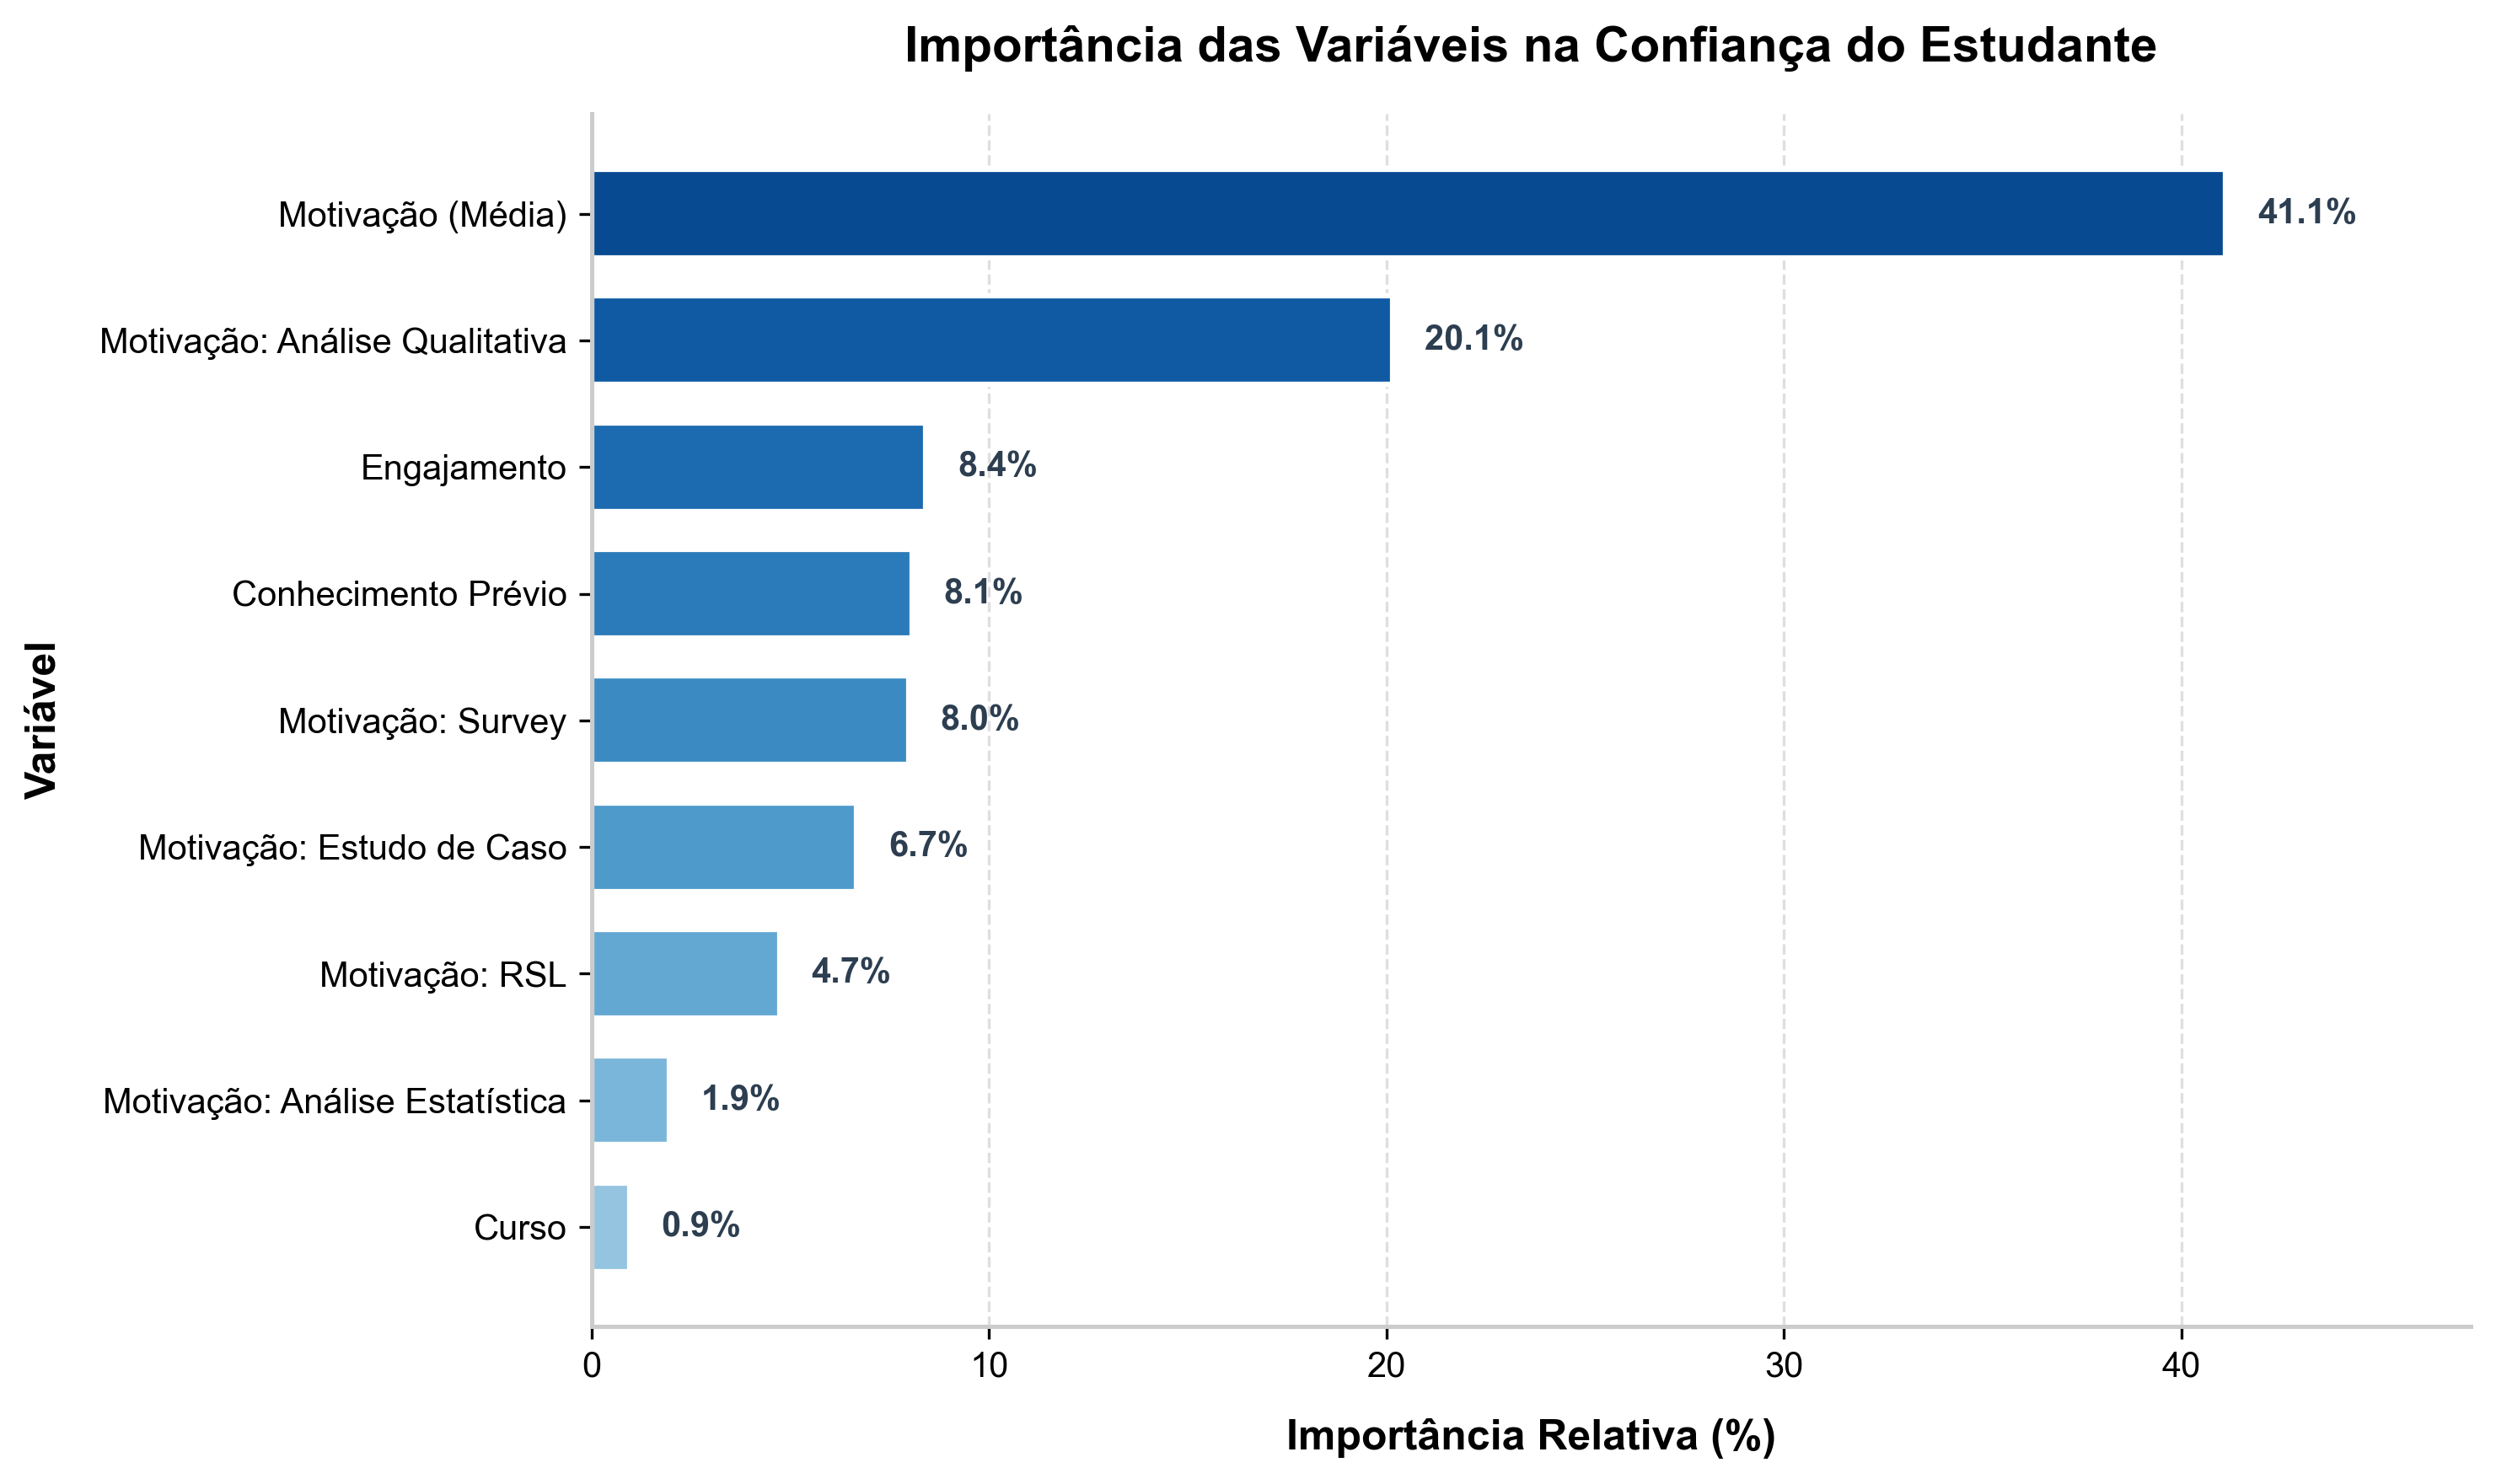

In [12]:
# Criar gráfico de feature importance melhorado para artigo
fig, ax = plt.subplots(figsize=(10, 6))

# Ordenar por importância
feature_importance_sorted = feature_importance.sort_values('Importance', ascending=True)

# Mapear nomes das features para versões mais legíveis
feature_names_map = {
    'Motivacao_Media': 'Motivação (Média)',
    'Análise Qualitativa': 'Motivação: Análise Qualitativa',
    'Engajamento': 'Engajamento',
    'Conhecimento_Previo': 'Conhecimento Prévio',
    'Survey': 'Motivação: Survey',
    'Estudo de caso': 'Motivação: Estudo de Caso',
    'Revisão Sistemática da Literatura (RSL)': 'Motivação: RSL',
    'Análise Estatística de Experimentos': 'Motivação: Análise Estatística',
    'Curso_Codificado': 'Curso'
}

# Criar labels melhorados
labels = [feature_names_map.get(f, f) for f in feature_importance_sorted['Feature']]

# Usar gradiente de cores profissional
n_features = len(feature_importance_sorted)
colors = plt.cm.Blues(np.linspace(0.4, 0.9, n_features))

# Criar gráfico de barras horizontal
bars = ax.barh(
    labels,
    feature_importance_sorted['Importance_Percent'],
    color=colors,
    edgecolor='white',
    linewidth=1.5,
    height=0.7
)

# Adicionar valores nas barras
for i, (bar, value) in enumerate(zip(bars, feature_importance_sorted['Importance_Percent'])):
    ax.text(
        value + 0.8, i, f'{value:.1f}%',
        va='center', fontsize=10, fontweight='bold',
        color='#2c3e50'
    )

# Configurações do eixo
ax.set_xlabel('Importância Relativa (%)', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('Variável', fontsize=12, fontweight='bold', labelpad=10)
ax.set_title('Importância das Variáveis na Confiança do Estudante', 
             fontsize=14, fontweight='bold', pad=15)

# Melhorar grid
ax.grid(axis='x', linestyle='--', alpha=0.4, linewidth=0.8)
ax.set_axisbelow(True)

# Remover bordas desnecessárias
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#cccccc')
ax.spines['bottom'].set_color('#cccccc')

# Limitar eixo x para melhor visualização
ax.set_xlim(0, max(feature_importance_sorted['Importance_Percent']) * 1.15)

plt.tight_layout()
plt.show()

# Salvar em alta resolução
# plt.savefig('../figures/feature_importance_confianca.png', dpi=300, bbox_inches='tight')


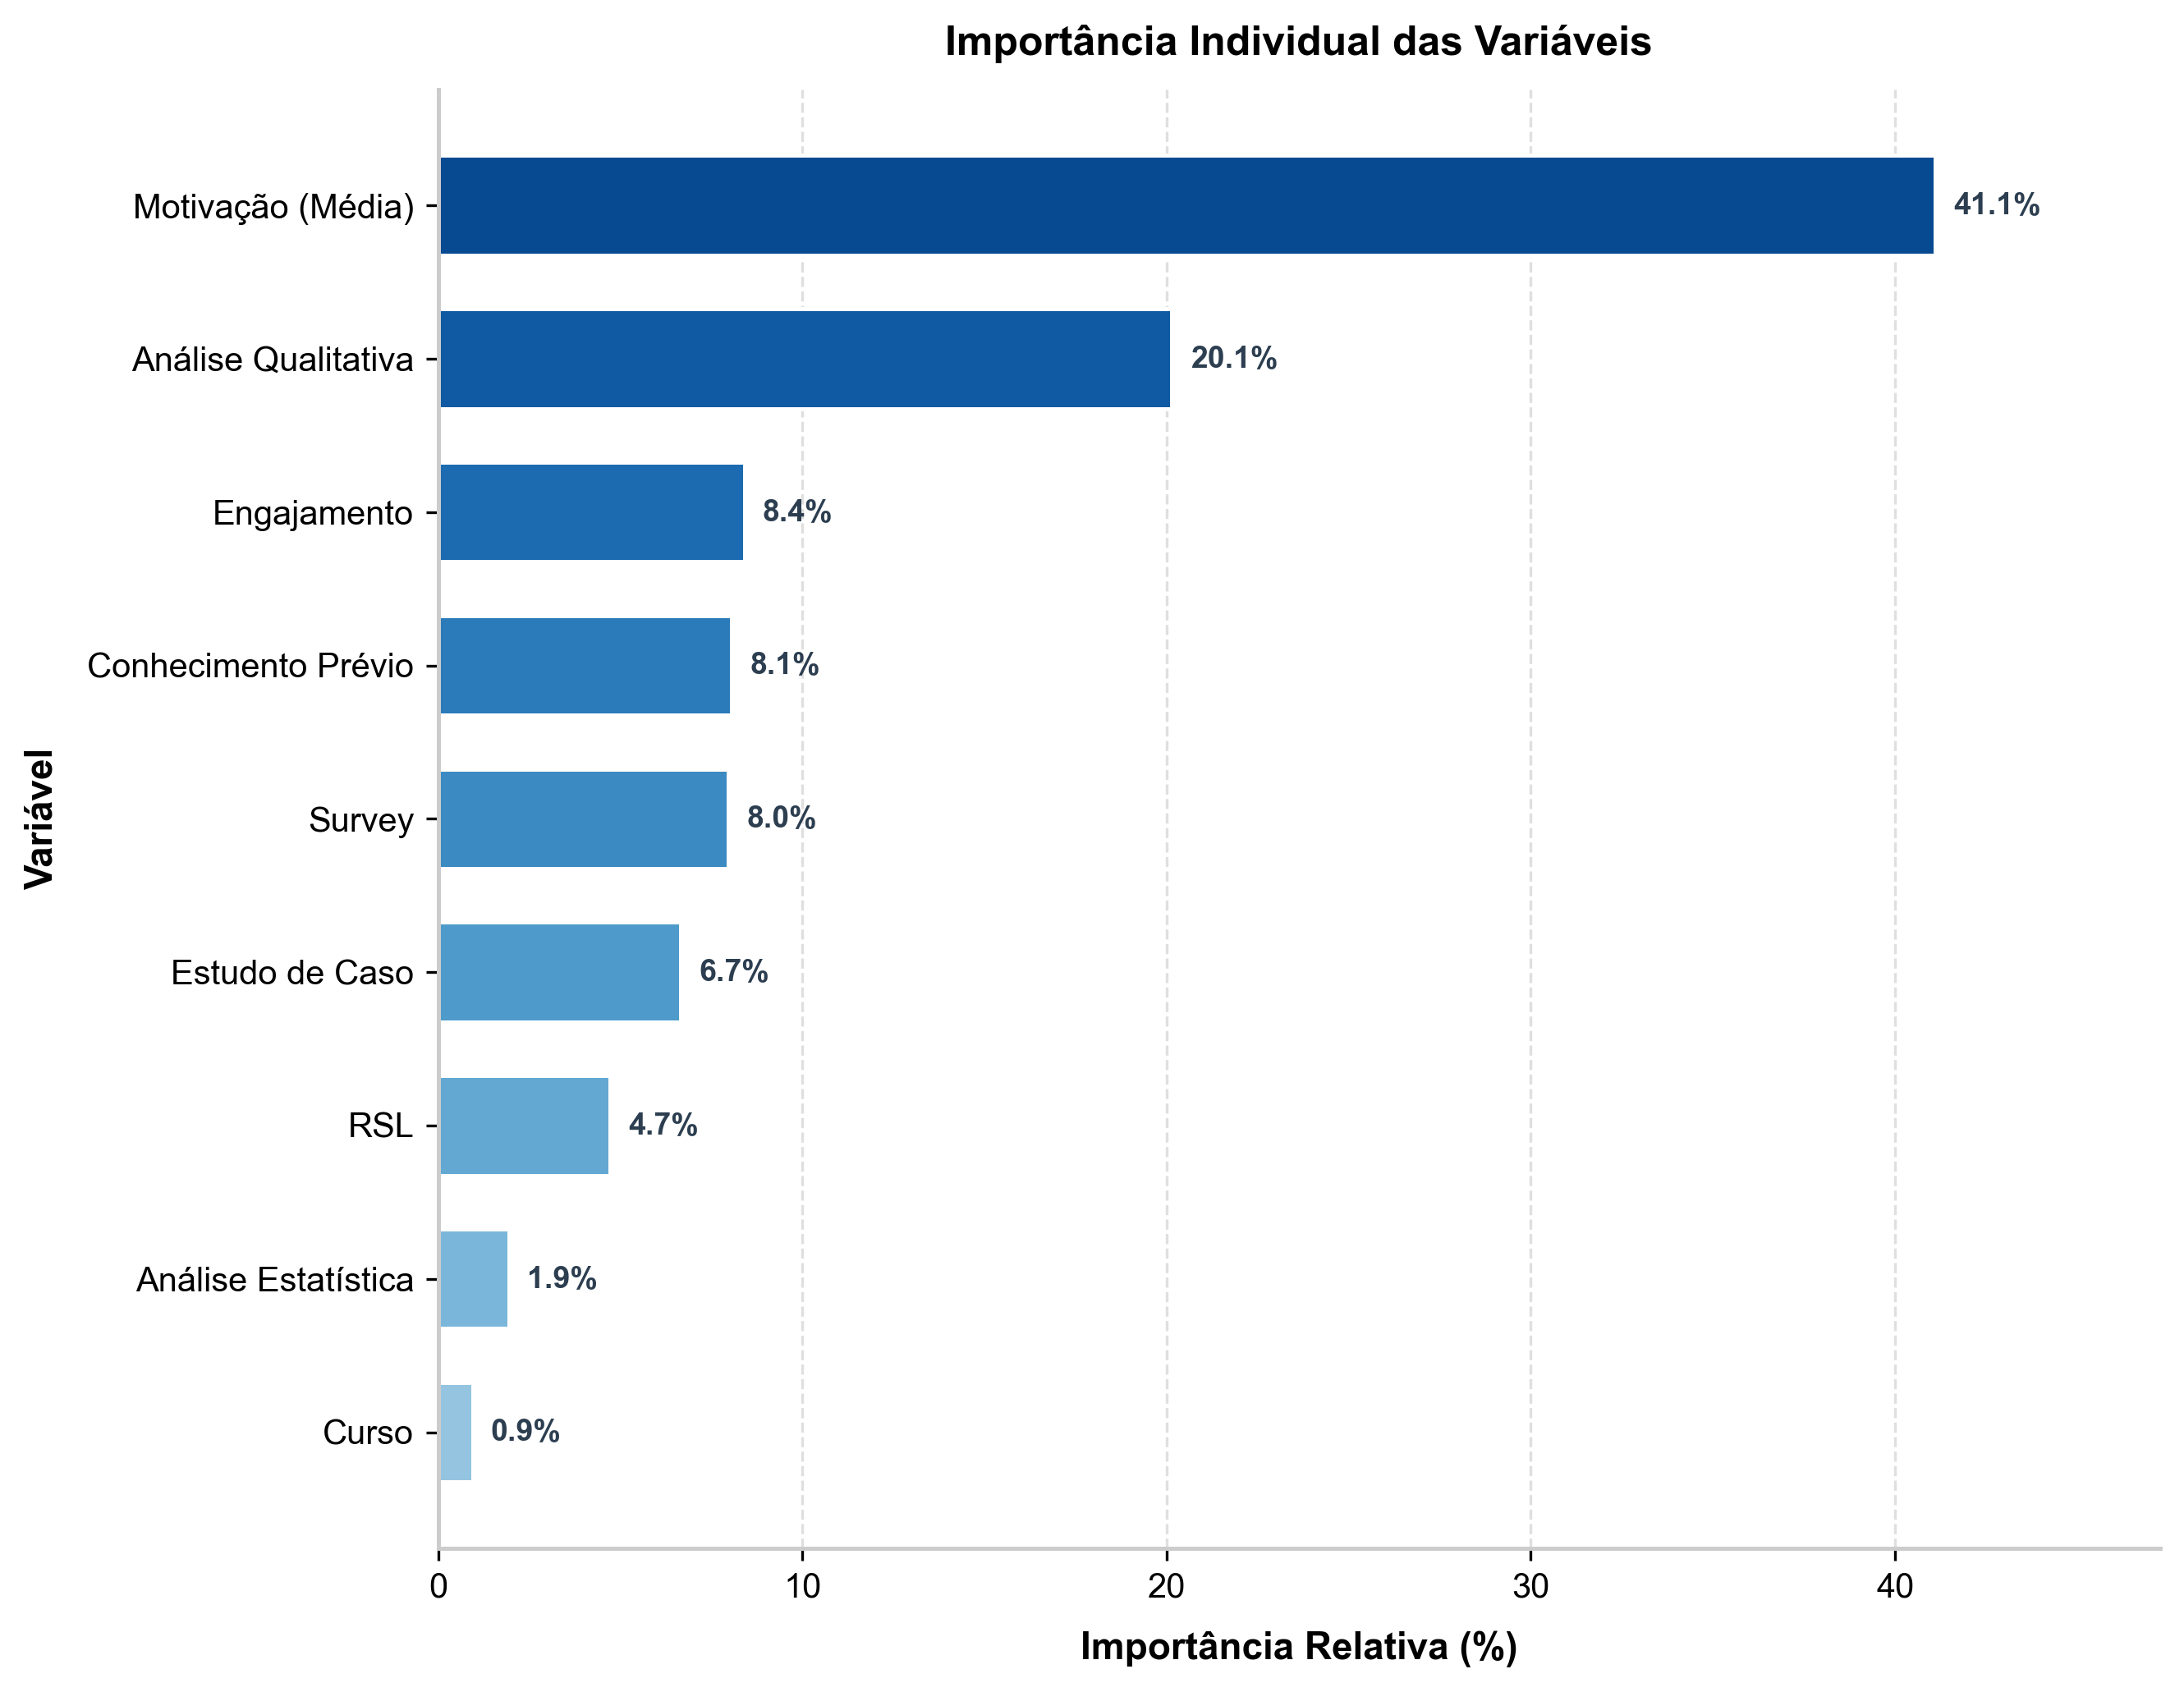

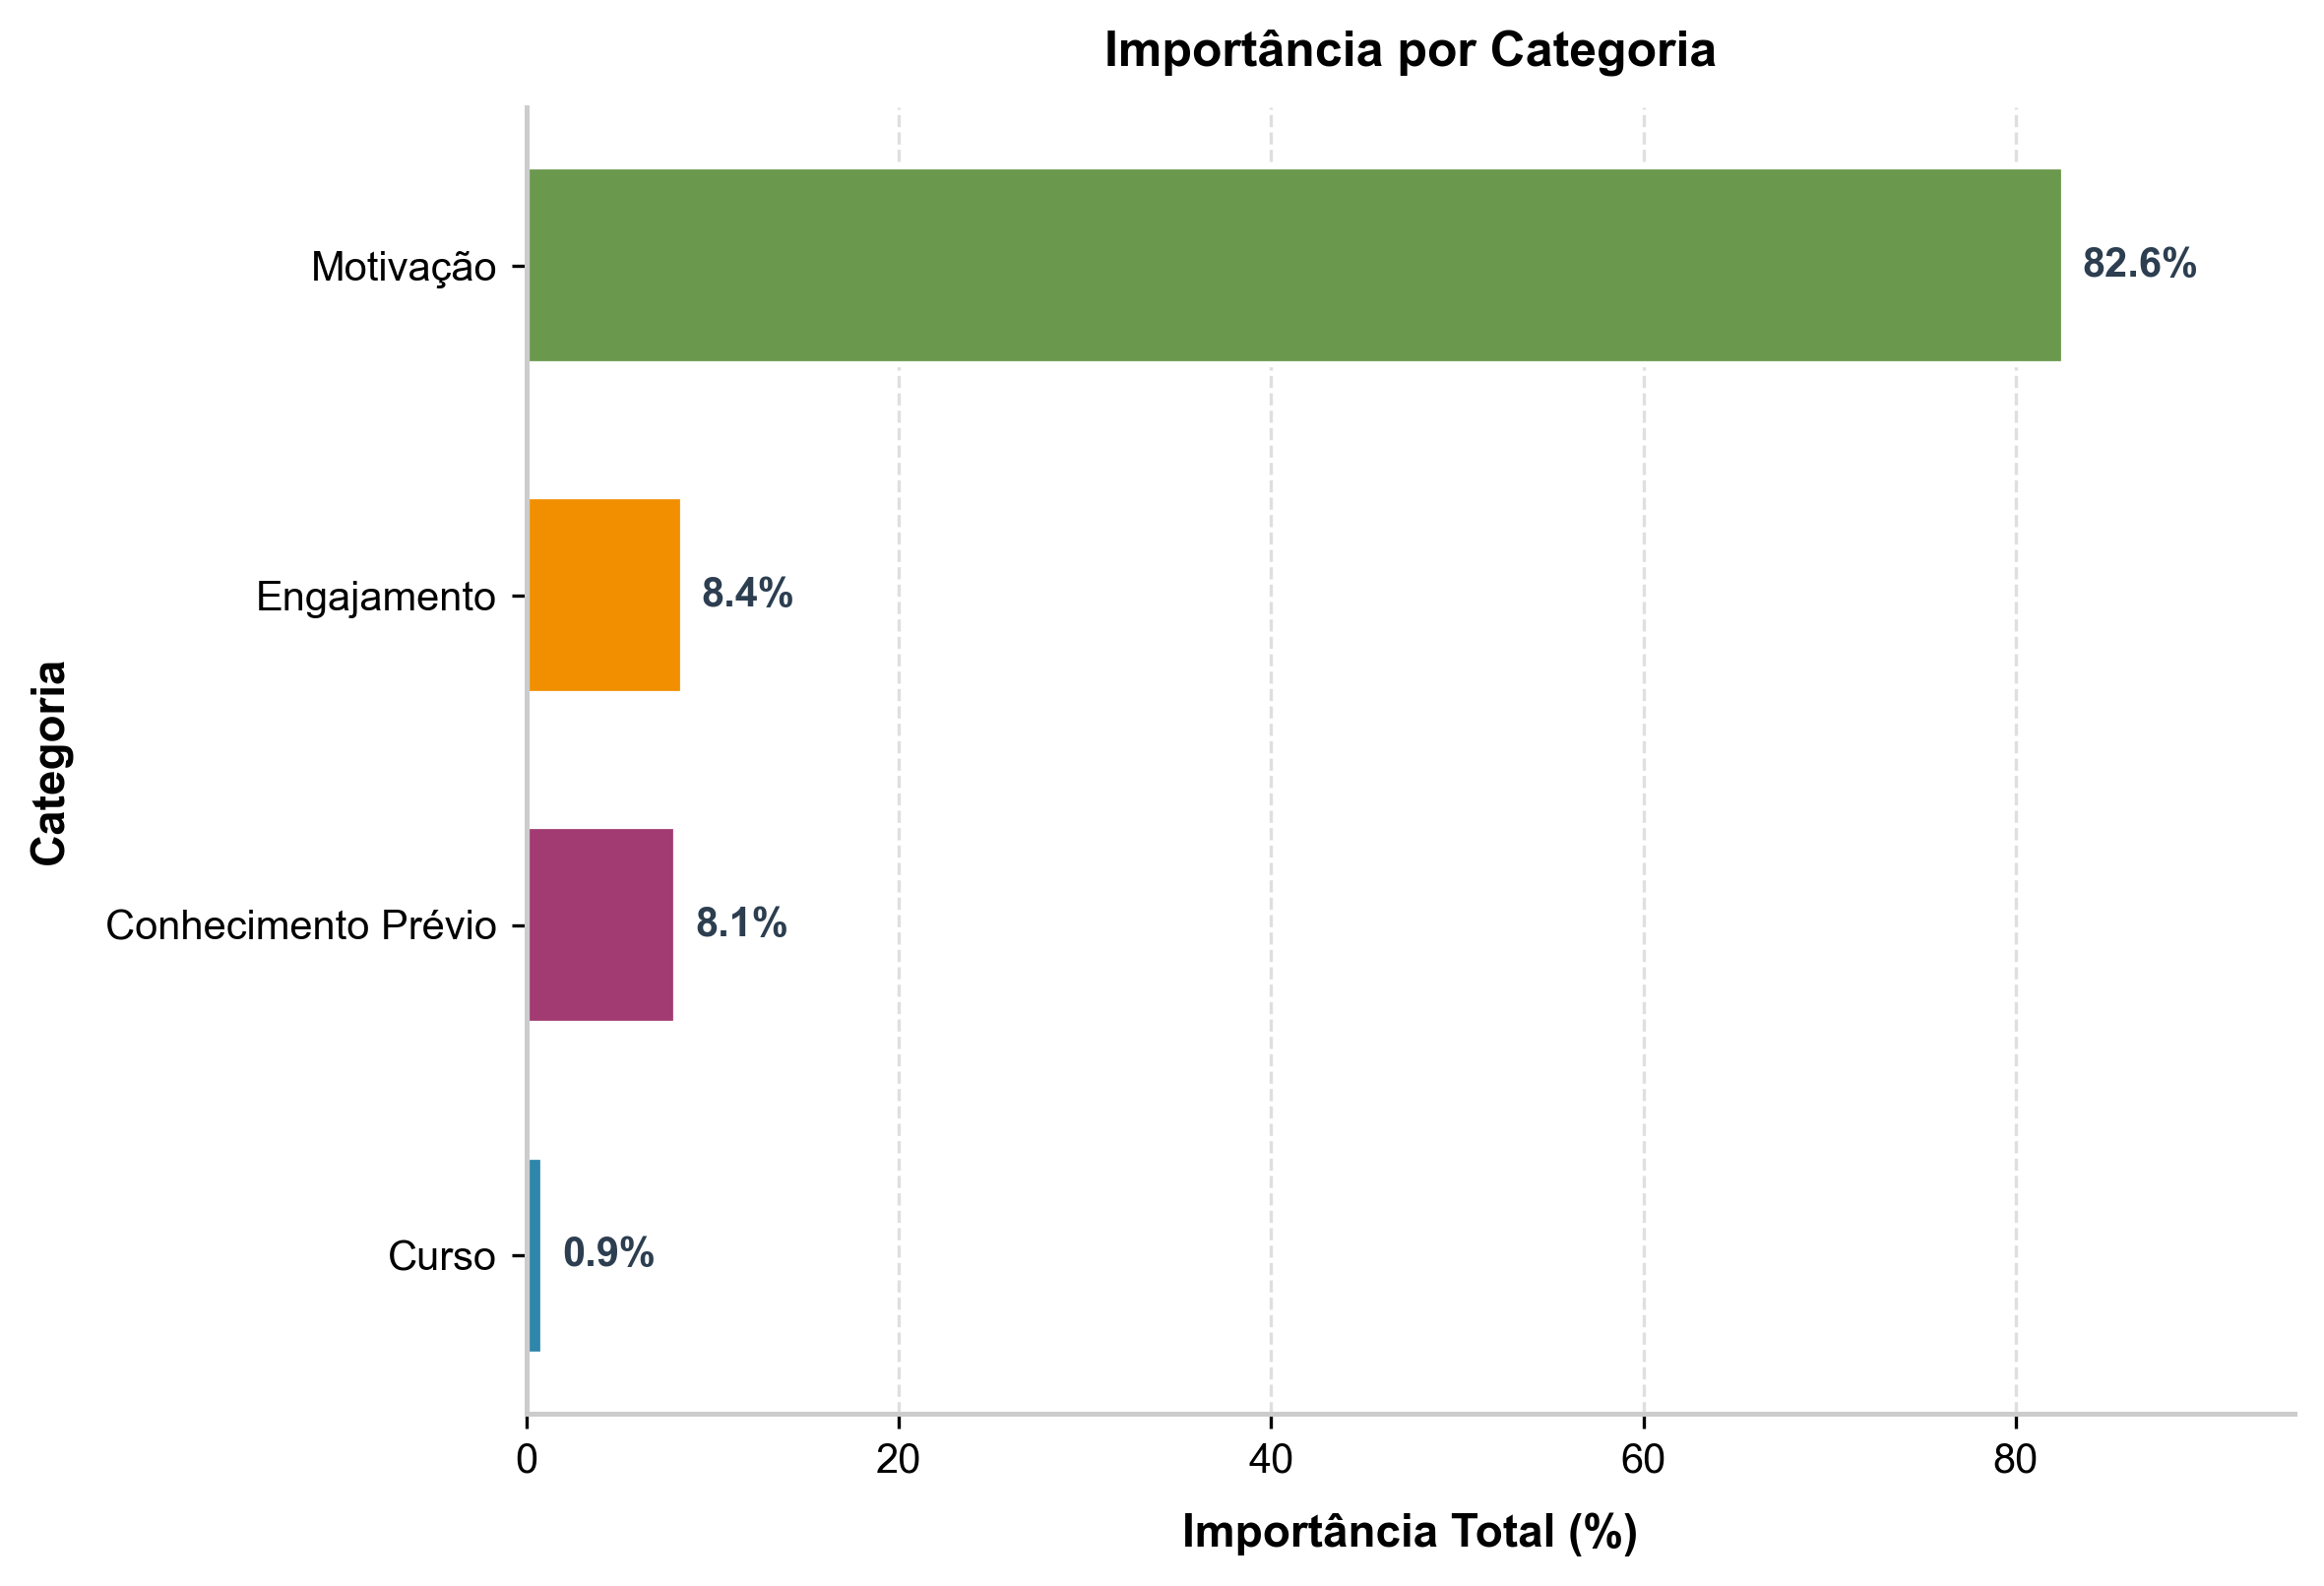


RESUMO POR CATEGORIA
Motivação                :  82.58%
Engajamento              :   8.41%
Conhecimento Prévio      :   8.06%
Curso                    :   0.95%


In [14]:
# Geração separada dos gráficos de importância individual e por categorias

# =========================
# Gráfico 1: Importância Individual
# =========================

# Mapear nomes das features para versões mais legíveis
feature_names_map = {
    'Motivacao_Media': 'Motivação (Média)',
    'Análise Qualitativa': 'Análise Qualitativa',
    'Engajamento': 'Engajamento',
    'Conhecimento_Previo': 'Conhecimento Prévio',
    'Survey': 'Survey',
    'Estudo de caso': 'Estudo de Caso',
    'Revisão Sistemática da Literatura (RSL)': 'RSL',
    'Análise Estatística de Experimentos': 'Análise Estatística',
    'Curso_Codificado': 'Curso'
}

feature_importance_sorted = feature_importance.sort_values('Importance', ascending=True)
labels_individual = [feature_names_map.get(f, f) for f in feature_importance_sorted['Feature']]

n_features = len(feature_importance_sorted)
colors_individual = plt.cm.Blues(np.linspace(0.4, 0.9, n_features))

fig_individual, ax_individual = plt.subplots(figsize=(9, 7))
bars1 = ax_individual.barh(labels_individual, 
                           feature_importance_sorted['Importance_Percent'],
                           color=colors_individual,
                           edgecolor='white',
                           linewidth=1.2,
                           height=0.65)

ax_individual.set_xlabel('Importância Relativa (%)', fontsize=11, fontweight='bold', labelpad=8)
ax_individual.set_ylabel('Variável', fontsize=11, fontweight='bold', labelpad=8)
ax_individual.set_title('Importância Individual das Variáveis', fontsize=12, fontweight='bold', pad=10)
ax_individual.grid(axis='x', linestyle='--', alpha=0.4, linewidth=0.8)
ax_individual.set_axisbelow(True)

# Remover bordas desnecessárias
for spine in ['top', 'right']:
    ax_individual.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax_individual.spines[spine].set_color('#cccccc')

ax_individual.set_xlim(0, max(feature_importance_sorted['Importance_Percent']) * 1.15)

for i, (bar, value) in enumerate(zip(bars1, feature_importance_sorted['Importance_Percent'])):
    ax_individual.text(value + 0.5, bar.get_y() + bar.get_height()/2, 
                       f'{value:.1f}%', va='center', fontsize=9, fontweight='bold',
                       color='#2c3e50')

plt.tight_layout()
plt.show()

# # Salvar em alta resolução (descomente para salvar)
# plt.savefig('../figures/feature_importance_individual.png', dpi=300, bbox_inches='tight')


# =========================
# Gráfico 2: Importância por Categoria
# =========================

# Agrupar features por categoria
categorias = {
    'Motivação': ['Motivacao_Media'] + [col for col in motiv_cols if col in features],
    'Conhecimento Prévio': ['Conhecimento_Previo'],
    'Engajamento': ['Engajamento'],
    'Curso': ['Curso_Codificado']
}

categoria_importance = {}
for categoria, vars_list in categorias.items():
    vars_in_model = [v for v in vars_list if v in feature_importance['Feature'].values]
    if vars_in_model:
        categoria_importance[categoria] = feature_importance[
            feature_importance['Feature'].isin(vars_in_model)
        ]['Importance_Percent'].sum()

if categoria_importance:
    cat_df = pd.DataFrame({
        'Categoria': list(categoria_importance.keys()),
        'Importance': list(categoria_importance.values())
    }).sort_values('Importance', ascending=True)
    
    # Cores distintas para cada categoria
    colors_categoria = ['#2E86AB', '#A23B72', '#F18F01', '#6A994E'][:len(cat_df)]
    
    fig_categoria, ax_categoria = plt.subplots(figsize=(8, 5.5))
    bars2 = ax_categoria.barh(cat_df['Categoria'], 
                              cat_df['Importance'], 
                              color=colors_categoria,
                              edgecolor='white',
                              linewidth=1.5,
                              height=0.6)
    
    ax_categoria.set_xlabel('Importância Total (%)', fontsize=11, fontweight='bold', labelpad=8)
    ax_categoria.set_ylabel('Categoria', fontsize=11, fontweight='bold', labelpad=8)
    ax_categoria.set_title('Importância por Categoria', fontsize=12, fontweight='bold', pad=10)
    ax_categoria.grid(axis='x', linestyle='--', alpha=0.4, linewidth=0.8)
    ax_categoria.set_axisbelow(True)
    
    # Remover bordas desnecessárias
    for spine in ['top', 'right']:
        ax_categoria.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax_categoria.spines[spine].set_color('#cccccc')
    
    ax_categoria.set_xlim(0, max(cat_df['Importance']) * 1.15)
    
    for i, (bar, value) in enumerate(zip(bars2, cat_df['Importance'])):
        ax_categoria.text(value + 1.0, bar.get_y() + bar.get_height()/2, 
                          f'{value:.1f}%', va='center', fontsize=10, fontweight='bold',
                          color='#2c3e50')
    
    plt.tight_layout()
    plt.show()
    # # Salvar em alta resolução (descomente para salvar)
    # plt.savefig('../figures/feature_importance_categorias.png', dpi=300, bbox_inches='tight')

    # Mostrar resumo por categoria
    print("\n" + "="*60)
    print("RESUMO POR CATEGORIA")
    print("="*60)
    for categoria, importance in sorted(categoria_importance.items(), key=lambda x: x[1], reverse=True):
        print(f"{categoria:25s}: {importance:6.2f}%")
    print("="*60)


## Conclusões

Com base no modelo Random Forest Regressor, podemos identificar quais variáveis mais influenciam a confiança do estudante:

### Principais Fatores Identificados:

1. **Motivação** - Representa 82.58% da importância total
2. **Engajamento** - Representa 8.41% da importância total  
3. **Conhecimento Prévio** - Representa 8.06% da importância total
4. **Curso** - Representa 0.95% da importância total

### Interpretação:

O modelo não-linear (Random Forest) captura interações complexas entre as variáveis, permitindo identificar não apenas relações lineares, mas também padrões mais sofisticados que influenciam a confiança do estudante.
